# Simulation of non-radiative capture

Shockley-Read-Hall (SRH) recombination is a key process in the limiting the performance of many optoelectronic devices.
Explicit, first-principles, calculations for the SRH recombination have recently become possible thanks to the work of the the Van de Walle group at UCSB.
Using the formally def

In [ ]:
from pathlib import Path
from pymatgen.analysis.defects.ccd import HarmonicDefect, SRHCapture
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
TEST_FILES = Path("../tests/test_files/v_Ga/")

## Read a single Harmonic Defect

We can parse an sorted list of directories with `HarmonicDefect.from_directories`.
This will look into each directory for a `vasprun.xml` file from which the structures and energies will be extracted.

The relax structure is automatically determined by the energies.

In [ ]:
dirs01 = [TEST_FILES / "ccd_0_-1" / str(i) for i in [0,1,2]]
hd0 = HarmonicDefect.from_directories(
    directories=dirs01,
    store_bandstructure=True,
)
hd0

HarmonicDefect(omega=0.505 eV, charge=0.0, relaxed_index=1, spin=1, defect_band=[(138, 0, 1), (138, 1, 1)])

The potential energy surface of the defect in a particular charge state is given by:

$$\frac{1}{2} \omega^2 Q^2$$

Text(0, 0.5, 'Energy [meV]')

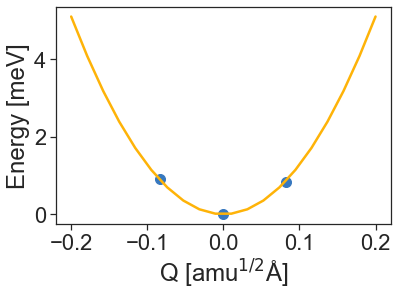

In [ ]:
plt.plot(hd0.distortions, (np.array(hd0.energies) - hd0.energies[hd0.relaxed_index]) * 1000, "o", ms=10)
xx = np.linspace(-0.2, 0.2, 20)
yy = 0.5 * hd0.omega**2 * xx ** 2
plt.plot(xx,yy*1000)
plt.xlabel("Q [amu$^{1/2}$Å]")
plt.ylabel("Energy [meV]")

The band index is automatically determined by the inverse participation ratio.

In [ ]:
print(f"The spin channel ({hd0.spin}) is also automaticalliy determined by the IPR.")

The spin channel (-1) is also automaticalliy determined by the IPR.


Text(0, 0.5, 'Energy Level Spin:-1')

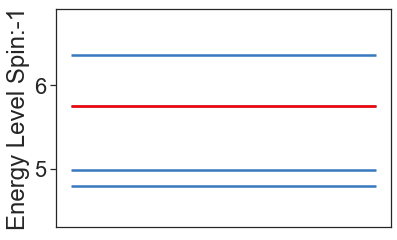

In [ ]:
bs = hd0.relaxed_bandstructure
eigs = bs.bands[hd0.spin][:,1]
eigs_ref_efermi = eigs
plt.hlines([eigs_ref_efermi], 0,1)
plt.hlines(eigs_ref_efermi[hd0.defect_band_index], 0,1, colors="red")
plt.ylim(bs.efermi-0.1,bs.efermi+2.5)
plt.xticks([]);
plt.ylabel(f"Energy Level Spin:{hd0.spin}")


From the eigenvalue file:

```
#   nband        eig (+1)        eig (-1)   occ (+1)   occ (-1)
    138          4.281429        4.983887   0.999759   0.000000
    139          4.341242        5.752503   0.963967   0.000000  <- Defect band
    140          6.269717        6.356752   0.000000   0.000000
    141          8.441992        8.536628   0.000000   0.000000
```

## Combined two HarmonicDefects and a series of WSWQ

Read the information required for SRH recombination from directories.

In [ ]:
srh = SRHCapture.from_directories(
    initial_dirs=[TEST_FILES / "ccd_0_-1" / str(i) for i in [0,1,2]],
    final_dirs=[TEST_FILES / "ccd_-1_0" / str(i) for i in [0,1,2]],
    wswq_dir = TEST_FILES / "ccd_0_-1" / "wswqs",
    store_bandstructure=True,
)


In [ ]:
T = np.linspace(100, 1000, 20)
cc = srh.get_coeff(T, 0.3, kpt_index=1)

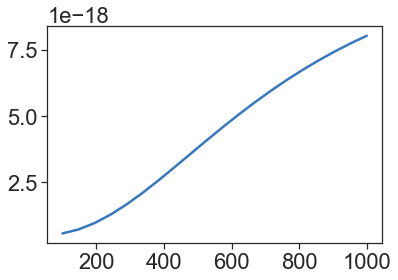

In [ ]:
plt.plot(T, cc)